# Assessing Read Quality

### Questions:
- How can I describe the quality of my data?
### Objectives:
- Explain how a FASTQ file encodes per-base quality scores.
- Interpret a FastQC plot summarizing per-base quality across all reads.
- Use `for` loops to automate operations on multiple files.
### Keypoints:
- It is important to know the quality of our data to make decisions in the subsequent steps.
- FastQC is a program that allows us to know the quality of FASTQ files.
- `for` loops let you perform the same operations on multiple files with a single command.

## Getting Started

In [ ]:
# set the variables for your netid
netid = "bonnie"

In [ ]:
# Go into the working directory
work_dir = "/xdisk/bhurwitz/bh_class/" + netid + "/exercises/06_qc_trimming"
%cd $work_dir

In [ ]:
# Create a variable for the data directory
data_dir = "/xdisk/bhurwitz/bh_class/" + netid + "/exercises/data/untrimmed_fastq"

## Quality control

We will now assess the quality of the sequence reads contained in our FASTQ files. 

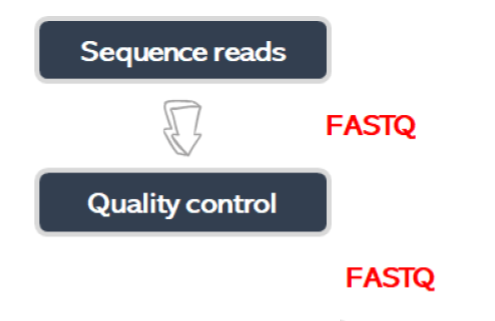

### Details on the FASTQ format

Although it looks complicated (and it is), we can understand the [FASTQ](https://en.wikipedia.org/wiki/FASTQ_format) format with a little decoding. Some rules about the format include the following:  

|Line|Description|   
|----|-----------|     
|1|Always begins with '@' followed by the information about the read|  
|2|The actual DNA sequence|  
|3|Always begins with a '+' and sometimes contains the same info as in line 1|  
|4|Has a string of characters which represent the quality scores; must have same number of characters as line 2|  

We can view the first complete read in one of the files from our dataset using `head` to look at
the first four lines. But we have to decompress one of the files first using `gzip -dc`.


In [ ]:
%cd $data_dir
!gzip -dc JP4D_R1.fastq.gz | head


```
@MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:12622:2006 1:N:0:CTCAGA
CCCGTTCCTCGGGCGTGCAGTCGGGCTTGCGGTCTGCCATGTCGTGTTCGGCGTCGGTGGTGCCGATCAGGGTGAAATCCGTCTCGTAGGGGATCGCGAAGATGATCCGCCCGTCCGTGCCCTGAAAGAAATAGCACTTGTCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAGCAAACCTCTCACTCCCTCTACTCTACTCCCTT                                        
+                                                                                                
A>>1AFC>DD111A0E0001BGEC0AEGCCGEGGFHGHHGHGHHGGHHHGGGGGGGGGGGGGHHGEGGGHHHHGHHGHHHGGHHHHGGGGGGGGGGGGGGGGHHHHHHHGGGGGGGGHGGHHHHHHHHGFHHFFGHHHHHGGGGGGGGGGGGGGGGGGGGGGGGGGGGFFFFFFFFFFFFFFFFFFFFFBFFFF@F@FFFFFFFFFFBBFF?@;@#################################### 
```

Line 4 shows the quality of each nucleotide in the read. Quality is interpreted as the probability of an incorrect base call (e.g., 1 in 10) or, equivalently, the base call accuracy (e.g., 90%). Each nucleotide's numerical score's value is converted into a character code where every single character represents a quality score for an individual nucleotide. This conversion allows the alignment of each individual nucleotide with its quality
score. For example, in the line above, the quality score line is: 

```
A>>1AFC>DD111A0E0001BGEC0AEGCCGEGGFHGHHGHGHHGGHHHGGGGGGGGGGGGGHHGEGGGHHHHGHHGHHHGGHHHHGGGGGGGGGGGGGGGGHHHHHHHGGGGGGGGHGGHHHHHHHHGFHHFFGHHHHHGGGGGGGGGGGGGGGGGGGGGGGGGGGGFFFFFFFFFFFFFFFFFFFFFBFFFF@F@FFFFFFFFFFBBFF?@;@#################################### 
```

The numerical value assigned to each character depends on the sequencing platform that generated the reads. The sequencing machine used to generate our data uses the standard Sanger quality PHRED score encoding, using Illumina version 1.8 onwards.
Each character is assigned a quality score between 0 and 41, as shown in the chart below.

```
Quality encoding: !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJ
                   |         |         |         |         |
Quality score:    01........11........21........31........41                                
```


Each quality score represents the probability that the corresponding nucleotide call is
incorrect. These probability values are the results of the base calling algorithm and depend on how 
much signal was captured for the base incorporation. This quality score is logarithmically based, so a quality score of 10 reflects a
base call accuracy of 90%, but a quality score of 20 reflects a base call accuracy of 99%. 
In this [link](https://drive5.com/usearch/manual/quality_score.html) you can find more information 
about quality scores.

Looking back at our read: 

```
@MISEQ-LAB244-W7:156:000000000-A80CV:1:1101:12622:2006 1:N:0:CTCAGA
CCCGTTCCTCGGGCGTGCAGTCGGGCTTGCGGTCTGCCATGTCGTGTTCGGCGTCGGTGGTGCCGATCAGGGTGAAATCCGTCTCGTAGGGGATCGCGAAGATGATCCGCCCGTCCGTGCCCTGAAAGAAATAGCACTTGTCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCTCAGAATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAGCAAACCTCTCACTCCCTCTACTCTACTCCCTT                                        
+                                                                                                
A>>1AFC>DD111A0E0001BGEC0AEGCCGEGGFHGHHGHGHHGGHHHGGGGGGGGGGGGGHHGEGGGHHHHGHHGHHHGGHHHHGGGGGGGGGGGGGGGGHHHHHHHGGGGGGGGHGGHHHHHHHHGFHHFFGHHHHHGGGGGGGGGGGGGGGGGGGGGGGGGGGGFFFFFFFFFFFFFFFFFFFFFBFFFF@F@FFFFFFFFFFBBFF?@;@#################################### 
```

We can now see that there is a range of quality scores but that the end of the sequence is very poor (`#` = a quality score of 2). 

> ## Exercise 1: Looking at specific reads  
> 
> In the terminal, how would you show the ID and quality of the last read `JP4D_R1.fastq`?  
> a) `tail JP4D_R1.fastq`  
> b) `head -n 4 JP4D_R1.fastq`  
> c) `more JP4D_R1.fastq`  
> d) `tail -n4 JP4D_R1.fastq`  
> e) `tail -n4 JP4D_R1.fastq | head -n2`  
>   
>   Do you trust the sequence in this read? 
> 
>> ## Solution
>> ~~~
>>   
>> a) It shows the ID and quality of the last read but also unnecessary lines from previous reads.  
>> b) No. It shows the first read's info.  
>> c) It shows the text of the entire file.  
>> d) This option is the best answer as it only shows the last read's information.  
>> e) It does show the ID of the last read but not the quality.  
>> 
>> ~~~